In [1]:
using Roots
using SteadyStateDiffEq
using PyPlot
using Revise
using Parameters

include("runMLM.jl")

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/claresinger/.julia/packages/PyPlot/4wzW1/src/init.jl:192


run_with_output (generic function with 1 method)

In [2]:
include("runMLM.jl")

par = interact_surf_params();
println(atmos_emissivity(par));

par.CO2 = 500.0;
println(atmos_emissivity(par));

par.CO2 = 800.0;
println(atmos_emissivity(par));

par.CO2 = 1200.0;
println(atmos_emissivity(par));

0.8
0.8297948589443854
0.8925512852639037
0.946690316536834


In [3]:
include("runMLM.jl")

par = interact_surf_params();
par.dSST = 0.0;
u0, uf = run_with_output(par);

OHU = calc_surf_RAD(uf,par) - calc_SHF(uf,par) - calc_LHF(uf,par);
println("OHU: ",OHU," (W/m^2)");

par = interact_surf_params();
par.dSST = 1.0;
par.OHU = OHU;
println(atmos_emissivity(par))
u0, uf = run_with_output(par);

Success
CO2: 400
u0: [900.0, 3.13275e5, 0.0096493, 290.0]
uf: [943.484, 3.12135e5, 0.00867047, 290.0]
du/u: [-5.83295e-11, 1.28914e-13, 7.49853e-12, 0.0]
we = 5.660848189620318 (mm/s)
zc = 409.77130789151477 (m)
RH0 = 75.26966128660824 (%)
LHF = 81.48866077692936 (W/m2)
SHF = 6.741913127597101 (W/m2)
LWP = 179.55777051664023 (g/m^2)
ΔR = 91.52691287373051 (W/m^2)

OHU: -36.43570461316585 (W/m^2)
0.8
Success
CO2: 400
u0: [900.0, 3.13275e5, 0.0096493, 290.0]
uf: [941.946, 3.12102e5, 0.00866628, 289.98]
du/u: [-1.37066e-11, -9.09534e-13, -5.16298e-12, -4.13764e-13]
we = 5.651665881831635 (mm/s)
zc = 410.16101209297835 (m)
RH0 = 75.3449404420089 (%)
LHF = 81.21238266998368 (W/m2)
SHF = 6.765312874079427 (W/m2)
LWP = 180.42956939795323 (g/m^2)
ΔR = 91.51949144943575 (W/m^2)



In [4]:
par = interact_surf_params();
par.dSST = 1.0;
par.OHU = OHU;
par.CO2 = 800.0;
println(atmos_emissivity(par))
u0, uf = run_with_output(par);

0.8925512852639037
Success
CO2: 800.0
u0: [900.0, 3.13275e5, 0.0096493, 290.0]
uf: [1434.96, 3.24938e5, 0.0104351, 297.111]
du/u: [1.26673e-11, 4.10581e-13, 7.11325e-13, -6.97216e-14]
we = 8.609769434216354 (mm/s)
zc = 195.76478286693305 (m)
RH0 = 52.82781404815397 (%)
LHF = 202.7332313261678 (W/m2)
SHF = -5.174055487323244 (W/m2)
LWP = 40.78243199063432 (g/m^2)
ΔR = 60.86803374515216 (W/m^2)



In [53]:
function run_exp(var, etype::ent_type, rtype::rad_type, ftype::flux_type)
    
    default = CPQ_params();
    
    num = 3;
    pert = 20/100; LHFs = default.LHF .* collect(range(1.0-pert, length=num, stop=1.0+pert));                                 
    pert = 24/100; DFRs = default.DFR .* collect(range(1.0-pert, length=num, stop=1.0+pert));
    pert = 90/100; SHFs = default.SHF .* collect(range(1.0-pert, length=num, stop=1.0+pert));
    pert = 6/100; Ds = default.D .* collect(range(1.0-pert, length=num, stop=1.0+pert));
    pert = 0.5/100; sft0s = default.sft0 .* collect(range(1.0-pert, length=num, stop=1.0+pert));
        
    # create empty arrays for output
    u0s = Any[];
    ufs = Any[];
    params = Any[];

    if var == "DFR"
        x_list = DFRs
    elseif var == "D"
        x_list = Ds
    elseif var == "inv"
        x_list = sft0s
    elseif var == "SST"
        x_list = SSTs
    elseif var == "LHF"
        x_list = LHFs
    elseif var == "SHF"
        x_list = SHFs
    end
    
    for x in x_list
        # define parameter array
        par = set_run_params([var],[x],etype,rtype,ftype);  
                        
        # run MLM to steady state
        u0, uf, par = run_steadystate(par);

        # print output
        println("u0: ",u0)
        println("uf: ",uf)
        du = zeros(4);
        mlm(du, uf, par, 0.0)
        println("du/u: ", du ./ uf)
        zi,hM,qM,SST = uf;
        println("we = ",we(zi,hM,qM,SST,par,par.etype,par.rtype)*1000, " (mm/s)")
        println("eta = ",calc_eta(uf,par));
        println("zb = ",LCL(zi,hM,qM)," (m)")
        println("RH0 = ",RH(0.0,hM,qM)*100.0," (%)")
        println("LHF = ",calc_LHF(qM,SST,par)," (W/m2)")
        println("SHF = ",calc_SHF(hM,qM,SST,par)," (W/m2)")
        println()

        # add output to array
        push!(u0s, u0)
        push!(ufs, uf)
        push!(params, par)
    end
    
    return u0s, ufs, params
end
                    
function run_dense_exp(var, etype::ent_type, rtype::rad_type, ftype::flux_type)
    default = CPQ_params();
    
    num = 7;
    pert = 10/100; LHFs = default.LHF .* collect(range(1.0-pert, length=num, stop=1.0+pert));                                 
    pert = 12/100; DFRs = default.DFR .* collect(range(1.0-pert, length=num, stop=1.0+pert));
    pert = 90/100; SHFs = default.SHF .* collect(range(1.0-pert, length=num, stop=1.0+pert));
    pert = 12/100; Ds = default.D .* collect(range(1.0-pert, length=num, stop=1.0+pert));
    pert = 0.5/100; sft0s = default.sft0 .* collect(range(1.0-pert, length=num, stop=1.0+pert));
        
    # create empty arrays for output
    u0s = Any[];
    ufs = Any[];
    params = Any[];

    if var == "DFR"
        x_list = DFRs
    elseif var == "D"
        x_list = Ds
    elseif var == "inv"
        x_list = sft0s
    elseif var == "SST"
        x_list = SSTs
    elseif var == "LHF"
        x_list = LHFs
    elseif var == "SHF"
        x_list = SHFs
    end
    
    for x in x_list
        # define parameter array
        par = set_run_params([var],[x],etype,rtype,ftype);  
                        
        # run MLM to steady state
        u0, uf, par = run_steadystate(par);

        # add output to array
        push!(u0s, u0)
        push!(ufs, uf)
        push!(params, par)
    end
    
    return u0s, ufs, params
end
                                        
function run_grid_exp(num, var1, var2, etype::ent_type, rtype::rad_type, ftype::flux_type, exp_type; bowen=-1.0)
    default = CPQ_params();
    
#     LHFs = default.LHF .* collect(range(1.0, length=num, stop=1.0+0.05));                         
#     DFRs = default.DFR .* collect(range(1.0, length=num, stop=1.0-0.06));
#     SHFs = default.SHF .* collect(range(1.0, length=num, stop=1.0-0.45));
#     Ds = default.D .* collect(range(1.0, length=num, stop=1.0-0.03));
#     sft0s = default.sft0 .* collect(range(1.0, length=num, stop=1.0-0.01));
                                            
    pert = 10/100; LHFs = default.LHF .* collect(range(1.0-pert, length=num, stop=1.0+pert));                                 
    pert = 12/100; DFRs = default.DFR .* collect(range(1.0-pert, length=num, stop=1.0+pert));
    pert = 90/100; SHFs = default.SHF .* collect(range(1.0-pert, length=num, stop=1.0+pert));
    pert = 12/100; Ds = default.D .* collect(range(1.0-pert, length=num, stop=1.0+pert));
    pert = 0.5/100; sft0s = default.sft0 .* collect(range(1.0-pert, length=num, stop=1.0+pert));
        
    # create empty arrays for output
    u0s = Any[];
    ufs = Any[];
    params = Any[];

    if var1 == "DFR"
        x1_list = DFRs
    elseif var1 == "SHF"
        x1_list = SHFs
    elseif var1 == "D"
        x1_list = Ds
    elseif var1 == "inv"
        x1_list = sft0s
    end
    if var2 == "LHF"
        x2_list = LHFs
    end
    
    for x1 in x1_list
        println(var1,"\t",x1);
        for x2 in x2_list
            println(var2,"\t",x2);
                                                    
            vars = [var1,var2];
            xs = [x1,x2];
            
            # define parameter array
            if exp_type == "baseline"
                par = set_baseline_run_params(vars,xs,etype,rtype,ftype);
            elseif exp_type == "bowen"
                par = set_fixedBo_run_params(vars,xs,etype,rtype,ftype,bowen);
            elseif exp_type == "SCT"
                par = set_SCT_run_params(vars,xs,etype,rtype,ftype);
            elseif exp_type == "CC"
                par = set_CC_run_params(vars,xs,etype,rtype,ftype);
            end
#             println(par);

            # run MLM to steady state
            u0, uf, par = run_steadystate(par);
                                                        
            # print output
            if num < 3
                println("u0: ",u0)
                println("uf: ",uf)
                du = zeros(4);
                mlm(du, uf, par, 0.0)
                println("du/u: ", du ./ uf)
                zi,hM,qM,SST = uf;
                println("we = ",we(zi,hM,qM,SST,par,par.etype,par.rtype)*1000, " (mm/s)")
                println("zb = ",LCL(zi,hM,qM)," (m)")
                println("RH0 = ",RH(0.0,hM,qM)*100.0," (%)")
                println("LHF = ",calc_LHF(qM,SST,par)," (W/m2)")
                println("SHF = ",calc_SHF(hM,qM,SST,par)," (W/m2)")
                println()
            end

            # add output to array
            push!(u0s, u0)
            push!(ufs, uf)
            push!(params, par)
        end
    end
    
    return u0s, ufs, params
end

run_grid_exp (generic function with 1 method)

In [41]:
include("ODE.jl")
include("ProfilePlots.jl")

ety = bflux();
rty = direct();
fty = fixFlux();
var_list = ["DFR","D","LHF","SHF","inv"];
var_list = ["DFR"];

#phi_list = ["theta","T","p","h","qt","ql","RH","cf","bflux"];
#phi_list = ["ql","theta","T","RH","bflux"];
phi_list = ["ql","theta"];

for (i,var) in enumerate(var_list)
    println("\n\n",var);
    u0s, ufs, params = run_exp(var, ety, rty, fty);
#     plot_three_profs_generic(ufs, params, "h", "qt", "ql", var)
#     for phi in phi_list
#         print(phi,"\t");
#         plot_prof_generic(ufs, params, phi, var);
#     end
end



DFR
Success
u0: [900.0, 3.13275e5, 0.0096493, 290.0]
uf: [922.867, 320646.0, 0.0103732, 290.0]
du/u: [1.51334e-13, 1.29155e-12, 8.77639e-12, 0.0]
we = 5.537203830580006 (mm/s)
eta = 0.8325710814212246
zb = 731.9108707949082 (m)
RH0 = 68.30682848122109 (%)
LHF = 107.0 (W/m2)
SHF = 2.299999999999997 (W/m2)

Success
u0: [900.0, 3.13275e5, 0.0096493, 290.0]
uf: [1007.21, 3.17323e5, 0.00958143, 290.0]
du/u: [-7.85208e-12, -9.21306e-13, -4.40594e-12, 0.0]
we = 6.043275596112881 (mm/s)
eta = 0.8727478302272093
zb = 712.3456557285426 (m)
RH0 = 68.79952761429549 (%)
LHF = 107.0 (W/m2)
SHF = 2.299999999999997 (W/m2)

Success
u0: [900.0, 3.13275e5, 0.0096493, 290.0]
uf: [1077.79, 3.14544e5, 0.0089837, 290.0]
du/u: [-1.00907e-12, -6.6968e-13, -4.12615e-12, 0.0]
we = 6.466740874609341 (mm/s)
eta = 0.8973780868894
zb = 671.3566575910717 (m)
RH0 = 70.11775027982766 (%)
LHF = 107.0 (W/m2)
SHF = 2.299999999999997 (W/m2)



In [52]:
ubase, pbase = run_base(ety, rty, fty);

CPQ_params
  SST0: Float64 290.0
  dSST: Float64 0.0
  D: Float64 6.0e-6
  DFR: Float64 74.0
  RHsurf: Float64 0.8
  RHft: Float64 0.25
  Gamma_q: Float64 -3.0e-6
  sft0: Int64 297
  Gamma_s: Float64 0.005
  qft0: Float64 0.006708503509872937
  A: Float64 2.0
  LHF: Float64 107.0
  SHF: Float64 2.3
  etype: bflux bflux()
  rtype: direct direct()
  ftype: fixFlux fixFlux()

Success
u0: [900.0, 3.13275e5, 0.0096493, 290.0]
uf: [1007.21, 3.17323e5, 0.00958143, 290.0]
du/u: [-7.85208e-12, -9.21306e-13, -4.40594e-12, 0.0]
we = 6.043275596112881 (mm/s)
zb = 712.3456557285426 (m)
RH0 = 68.79952761429549 (%)
LHF = 107.0 (W/m2)
SHF = 2.299999999999997 (W/m2)



In [77]:
zi0, hM0, qtM0, SST0 = ubase;
lwp0 = calc_LWP(zi0,hM0,qtM0) * 1000.0;
println(lwp0);

94.91052182394169


In [74]:
var = "SHF";
u0s, ufs, params = run_dense_exp(var, ety, rty, fty);

Success
Success
Success
Success
Success
Success
Success


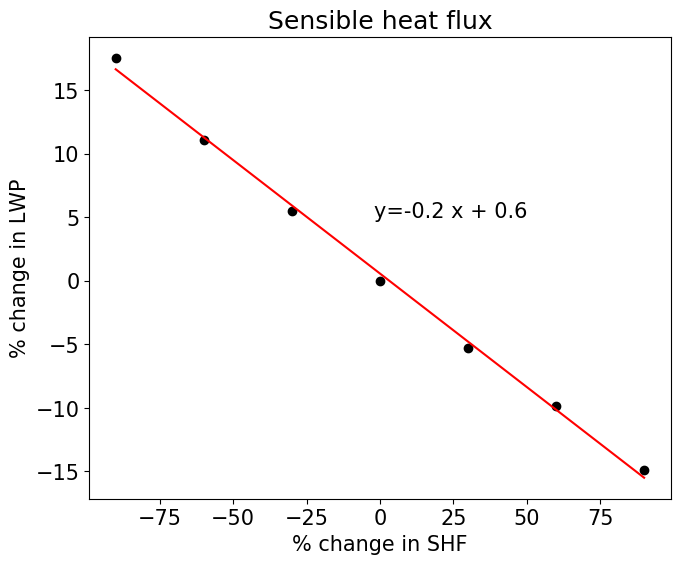

slope = -0.17851119298242876


In [75]:
include("LinAnalysis.jl")
plot_lwp(ubase, pbase, ufs, params, var);